## Dataset Preparation
This splits data into training 80% testing 10% and validation 10%
1.Training set (80%) → used by model to learn patterns.
2.Validation set (10%) → used during training to tune hyperparameters & stop overfitting.
3.Test set (10%) → used only at the end to check final accuracy on unseen data.
 Important: Never test on training data, otherwise accuracy will be misleading.

In [2]:
import os, random, shutil, json
from pathlib import Path

# 1. Source (where your extracted dataset is)
SRC = Path("D:/ISL_dataset")  
# Example: "C:/Users/YourName/Projects/ISL_dataset"

# 2. Destination (new folder where split will be stored)
DST = Path("ISL_dataset_split")

# 3. Percentages for split
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.8, 0.1, 0.1

# 4. Set seed for reproducibility
random.seed(42)

# 5. Create folders
for sub in ["train", "val", "test"]:
    (DST / sub).mkdir(parents=True, exist_ok=True)

label_map = {}  # class → id mapping

for i, class_dir in enumerate(sorted(SRC.iterdir())):
    if not class_dir.is_dir():
        continue
    label_map[class_dir.name] = i
    
    # list all image files in this class
    files = [f for f in class_dir.iterdir() if f.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp"]]
    random.shuffle(files)
    n = len(files)

    n_train = int(n * TRAIN_RATIO)
    n_val = int(n * VAL_RATIO)
    n_test = n - n_train - n_val

    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]

    # copy files into new structure
    for f in train_files:
        target = DST / "train" / class_dir.name
        target.mkdir(parents=True, exist_ok=True)
        shutil.copy(f, target / f.name)

    for f in val_files:
        target = DST / "val" / class_dir.name
        target.mkdir(parents=True, exist_ok=True)
        shutil.copy(f, target / f.name)

    for f in test_files:
        target = DST / "test" / class_dir.name
        target.mkdir(parents=True, exist_ok=True)
        shutil.copy(f, target / f.name)

# save label map for later use
with open(DST/"label_map.json", "w") as f:
    json.dump(label_map, f, indent=2)

print("✅ Dataset successfully split into train/val/test")
print("Label map saved at:", DST/"label_map.json")


✅ Dataset successfully split into train/val/test
Label map saved at: ISL_dataset_split\label_map.json


# Data Preprocessing & Augmentation
## Why preprocessing is needed?
dataset may have different image sizes → ML models need a fixed size (e.g., 224×224).
Images may be in different lighting/backgrounds → normalization helps reduce noise.
Some classes may have fewer images than others → augmentation balances them.
## Preprocessing Tasks
Resize images → Standardize size (e.g., 224×224 or 128×128).
Convert to tensors → PyTorch or TensorFlow works with tensors
Normalize pixel values → Bring them in range [0,1] or [-1,1].
Apply augmentation
## What is Data Augmentation?
It’s a way to artificially expand your dataset by applying transformations:
Random rotation (tilt images slightly)
Flipping (mirror images)
Brightness & contrast adjustmen
Zoom or crop
Slight shifts
This helps the model generalize better and avoid overfitting.

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size (all images will be resized to this shape)
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Preprocessing + Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,            # ✅ Preprocessing (normalization)
    rotation_range=20,         # ✅ Augmentation (rotation)
    width_shift_range=0.2,     # ✅ Augmentation (shift width)
    height_shift_range=0.2,    # ✅ Augmentation (shift height)
    shear_range=0.2,           # ✅ Augmentation (shear)
    zoom_range=0.2,            # ✅ Augmentation (zoom)
    horizontal_flip=True,      # ✅ Augmentation (flip)
    fill_mode='nearest'        # Fill gaps after transformation
)

# Preprocessing ONLY (No Augmentation) for Validation/Test Data
test_val_datagen = ImageDataGenerator(
    rescale=1./255   # ✅ Only normalization
)

# Training dataset
train_generator = train_datagen.flow_from_directory(
    "C:/Users/prati/OneDrive/Desktop/SignLanguage_Project/notebooks/ISL_dataset_split/train",   # ✅ Path where training data is stored
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',   # ✅ One-hot encoding labels
    shuffle=True
)

# Validation dataset
val_generator = test_val_datagen.flow_from_directory(
    "C:/Users/prati/OneDrive/Desktop/SignLanguage_Project/notebooks/ISL_dataset_split/val",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Testing dataset
test_generator = test_val_datagen.flow_from_directory(
    "C:/Users/prati/OneDrive/Desktop/SignLanguage_Project/notebooks/ISL_dataset_split/test",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ✅ Print class labels (important!)
print("Class Indices:", train_generator.class_indices)


Found 34195 images belonging to 35 classes.
Found 4272 images belonging to 35 classes.
Found 4278 images belonging to 35 classes.
Class Indices: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, 'A': 9, 'B': 10, 'C': 11, 'D': 12, 'E': 13, 'F': 14, 'G': 15, 'H': 16, 'I': 17, 'J': 18, 'K': 19, 'L': 20, 'M': 21, 'N': 22, 'O': 23, 'P': 24, 'Q': 25, 'R': 26, 'S': 27, 'T': 28, 'U': 29, 'V': 30, 'W': 31, 'X': 32, 'Y': 33, 'Z': 34}


# Scan for corrupted images and remove/skip them
Generate a manifest.csv mapping every image → label → folder
## What this does:
Checks every image in your dataset and skips or deletes corrupted ones.
Creates a manifest CSV for easy debugging and reproducibility.
You can now safely load images for training knowing that:
No corrupted files will crash TensorFlow
You have a clear mapping of file → label → folder

In [6]:
import os
import pandas as pd
from PIL import Image

# ====== CONFIG ======
data_dir = "C:/Users/prati/OneDrive/Desktop/SignLanguage_Project/datasets/ISL_dataset" # e.g. "./data/sign_images"
manifest_file = "manifest.csv"

# ====== HELPER FUNCTIONS ======
def is_image_ok(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Verify that it's not corrupted
        return True
    except Exception as e:
        print(f"Corrupted image skipped: {file_path} -> {e}")
        return False

# ====== MAIN PROCESS ======
rows = []

for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                file_path = os.path.join(class_path, file)
                if is_image_ok(file_path):
                    rows.append([file, class_folder, class_path])
                else:
                    # Optionally delete corrupted file
                    os.remove(file_path)  
                    print(f"Deleted corrupted file: {file_path}")

# ====== CREATE MANIFEST CSV ======
df = pd.DataFrame(rows, columns=["filename", "label", "class_folder"])
df.to_csv(manifest_file, index=False)
print(f"Manifest file created: {manifest_file} with {len(df)} entries")


Manifest file created: manifest.csv with 42745 entries


# prepare dataset in TensorFlow for training
(TensorFlow dataset pipeline) → run every time you train your model.
It reads the manifest, loads images safely, applies safe augmentations, and prepares the dataset for training.
Doesn’t modify files on disk, just processes them on the fly.

In [7]:
import tensorflow as tf
import pandas as pd
import os

# ====== CONFIG ======
manifest_file = "manifest.csv"
img_size = (128, 128)   # Resize all images to 128x128
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# ====== LOAD MANIFEST ======
df = pd.read_csv(manifest_file)
print(f"Total images: {len(df)}")

# Map class names to integers
class_names = sorted(df['label'].unique())
class_to_index = {name: idx for idx, name in enumerate(class_names)}
df['label_idx'] = df['label'].map(class_to_index)

# ====== HELPER FUNCTION TO LOAD IMAGE SAFELY ======
def load_image_safe(path, label):
    try:
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3)
        img.set_shape([None, None, 3])
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32) / 255.0  # Normalize
        return img, label
    except Exception as e:
        # Return a dummy image if something goes wrong (won't crash pipeline)
        print(f"Error loading {path}: {e}")
        return tf.zeros([*img_size, 3]), label

# ====== SAFE AUGMENTATION FUNCTION ======
def augment_image(img, label):
    img = tf.image.random_brightness(img, max_delta=0.1)   # small brightness change
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)  # contrast jitter
    img = tf.image.random_zoom(img, [0.9, 1.1]) if hasattr(tf.image, "random_zoom") else img
    # Optional small rotations
    img = tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return img, label

# ====== CREATE TF DATASET ======
paths = df['class_folder'] + '/' + df['filename']
labels = df['label_idx'].values

dataset = tf.data.Dataset.from_tensor_slices((paths.values, labels))
dataset = dataset.map(load_image_safe, num_parallel_calls=AUTOTUNE)
dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)
dataset = dataset.shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)

# ====== SPLIT DATASET ======
train_size = int(0.8 * len(df))
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

print("Dataset ready for training!")


Total images: 42745
Dataset ready for training!


# build the landmark model (mediaPipe)
Extract hand landmarks using MediaPipe.
Convert each image into a fixed-length vector.
Train a small MLP on these vectors.
Evaluate and save the model.
## Notes:
This is a fast baseline, usually gets decent accuracy within minutes
If accuracy is low:
Increase neurons in layers (256 → 512, 128 → 256)
Use a small RandomForest classifier instead of MLP
Make sure dataset is clean and signer-independent if possible

In [8]:
# ====== landmark_pipeline.py ======
import cv2, os, numpy as np
from pathlib import Path
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# ====== CONFIG ======
dataset_dir = Path("C:/Users/prati/OneDrive/Desktop/SignLanguage_Project/datasets/ISL_dataset")  # e.g. "./data/sign_images"
output_model = "landmark_model.h5"

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)

# ====== BUILD LABEL MAP ======
label_map = {d.name:i for i,d in enumerate(sorted([x for x in dataset_dir.iterdir() if x.is_dir()]))}

X, Y = [], []

# ====== EXTRACT LANDMARKS ======
for cls in sorted(dataset_dir.iterdir()):
    if not cls.is_dir(): continue
    label = label_map[cls.name]
    for img_path in cls.iterdir():
        if img_path.suffix.lower() not in ('.jpg','.jpeg','.png','.bmp'): continue
        img = cv2.imread(str(img_path))
        if img is None: continue
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        res = hands.process(rgb)

        vec = np.zeros(21*3*2, dtype=np.float32)  # 126 features
        if res.multi_hand_landmarks and res.multi_handedness:
            hand_map = {}
            for idx, hand_landmarks in enumerate(res.multi_hand_landmarks):
                hand_label = res.multi_handedness[idx].classification[0].label  # "Left" or "Right"
                coords = []
                for lm in hand_landmarks.landmark:
                    coords.extend([lm.x, lm.y, lm.z])
                hand_map[hand_label] = coords
            left = hand_map.get("Left", [0]*(21*3))
            right = hand_map.get("Right", [0]*(21*3))
            vec = np.array(left + right, dtype=np.float32)
        X.append(vec)
        Y.append(label)

X = np.stack(X)
Y = np.array(Y, dtype=np.int32)

print("Landmarks extracted:", X.shape, Y.shape)

# ====== SPLIT DATA ======
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ====== BUILD MLP MODEL ======
num_classes = len(label_map)

model = models.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# ====== TRAIN MODEL ======
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(output_model, save_best_only=True)
]

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=50, batch_size=64, callbacks=callbacks)

# ====== EVALUATE ======
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# ====== SAVE MODEL ======
model.save(output_model)
print("Saved landmark-based model to", output_model)


Landmarks extracted: (42745, 126) (42745,)
Epoch 1/50
532/535 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6798 - loss: 1.2265

535/535 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8573 - loss: 0.5596 - val_accuracy: 0.9841 - val_loss: 0.0717
Epoch 2/50
531/535 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9722 - loss: 0.1089

535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9747 - loss: 0.0977 - val_accuracy: 0.9871 - val_loss: 0.0467
Epoch 3/50
522/535 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9787 - loss: 0.0793

535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9806 - loss: 0.0713 - val_accuracy: 0.9885 - val_loss: 0.0397
Epoch 4/50
520/535 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9815 - loss: 0.0654

535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9830 - loss: 0.0600 - val_accuracy: 0.9897 - val_loss: 0.0357
Epoch 5/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9835 - loss: 0.0549 - val_accuracy: 0.9892 - val_loss: 0.0372
Epoch 6/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 97s 182ms/step - accuracy: 0.9851 - loss: 0.0507 - val_accuracy: 0.9897 - val_loss: 0.0365
Epoch 7/50
519/535 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0526

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9853 - loss: 0.0489 - val_accuracy: 0.9904 - val_loss: 0.0294
Epoch 8/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9867 - loss: 0.0454 - val_accuracy: 0.9909 - val_loss: 0.0326
Epoch 9/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9868 - loss: 0.0459 - val_accuracy: 0.9909 - val_loss: 0.0321
Epoch 10/50
527/535 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9882 - loss: 0.0414

535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9872 - loss: 0.0424 - val_accuracy: 0.9904 - val_loss: 0.0294
Epoch 11/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9868 - loss: 0.0453 - val_accuracy: 0.9913 - val_loss: 0.0302
Epoch 12/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9872 - loss: 0.0407 - val_accuracy: 0.9911 - val_loss: 0.0329
Epoch 13/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9869 - loss: 0.0429 - val_accuracy: 0.9909 - val_loss: 0.0323
Epoch 14/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9881 - loss: 0.0391 - val_accuracy: 0.9906 - val_loss: 0.0332
Epoch 15/50
524/535 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9856 - loss: 0.0461

535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9871 - loss: 0.0422 - val_accuracy: 0.9918 - val_loss: 0.0290
Epoch 16/50
532/535 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0395

535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9881 - loss: 0.0376 - val_accuracy: 0.9918 - val_loss: 0.0274
Epoch 17/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9883 - loss: 0.0384 - val_accuracy: 0.9918 - val_loss: 0.0284
Epoch 18/50
534/535 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9883 - loss: 0.0375

535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9877 - loss: 0.0396 - val_accuracy: 0.9932 - val_loss: 0.0245
Epoch 19/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9889 - loss: 0.0367 - val_accuracy: 0.9909 - val_loss: 0.0294
Epoch 20/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9878 - loss: 0.0404 - val_accuracy: 0.9920 - val_loss: 0.0262
Epoch 21/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9881 - loss: 0.0374 - val_accuracy: 0.9918 - val_loss: 0.0277
Epoch 22/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9881 - loss: 0.0376 - val_accuracy: 0.9923 - val_loss: 0.0266
Epoch 23/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9883 - loss: 0.0379 - val_accuracy: 0.9923 - val_loss: 0.0252
Epoch 24/50
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9887 - loss: 0.0361 - val_accuracy: 0.9909 - val_loss: 0.0281
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9890 - loss: 0.0341


Test accuracy: 0.9890058636665344
Saved landmark-based model to landmark_model.h5


# Just suggestion for accuarcy as landmark has less accruacy 
Step 1: Extract landmarks
Use the script I gave earlier (landmark_pipeline.py).
This will convert all images into 126-length vectors per sample.
Output: X (landmark vectors), Y (labels).

Step 2: Split the dataset

Train / validation / test split is already included in the script.

Makes sure your model is tested on unseen data.

Step 3: Build and train MLP

The script already builds a small fully connected network.

Training will be fast (minutes even on CPU).

Monitor validation accuracy to avoid overfitting.

Step 4: Evaluate & save

Test accuracy will give you a baseline performance.

The model is saved as landmark_model.h5 for future use.

💡 Tip:

If you want better results later, you can tweak:

Number of neurons in dense layers (128 → 256)

Dropout rates

Batch size / learning rate

# Evaluation & Metrics
## Purpose

Understand which signs are predicted well and which are often confused.

Gives insight into dataset quality and model weaknesses.
## How to do it

Load your trained landmark model (landmark_model_saved).

Use the same train/val/test split you used during training.

Predict on the test set:

In [10]:
preds = model.predict(X_test)        # X_test from your split
y_pred = preds.argmax(axis=1)


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      1.00      1.00       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120
           4       1.00      1.00      1.00       120
           5       1.00      1.00      1.00       120
           6       1.00      1.00      1.00       120
           7       1.00      1.00      1.00       120
           8       1.00      1.00      1.00       120
           9       1.00      0.99      1.00       120
          10       1.00      0.97      0.99       120
          11       0.98      0.89      0.93       145
          12       1.00      1.00      1.00       120
          13       1.00      1.00      1.00       120
          14       1.00      1.00      1.00       120
          15       0.99      0.99      0.99       120
          16       0.99      1.00      1.00       120
          17       1.00    

In [22]:
import numpy as np
X = np.stack(X)   # Converts your list of landmark vectors to a NumPy array
Y = np.array(Y)   # Converts your list of labels to a NumPy array

np.savez_compressed(
    "C:/Users/prati/OneDrive/Desktop/SignLanguage_Project/notebooks/landmarks_dataset.npz",
    X=X,
    Y=Y,
    label_map=label_map
)


In [23]:
data = np.load(
    "C:/Users/prati/OneDrive/Desktop/SignLanguage_Project/notebooks/landmarks_dataset.npz",
    allow_pickle=True   # needed because label_map is a dictionary
)

X = data["X"]
Y = data["Y"]
label_map = data["label_map"].item()  # converts back to dictionary


In [2]:
# evaluate.py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# -------------------------------
# Step 1: Load your model
# -------------------------------
model_path = "C:/Users/prati/OneDrive/Desktop/SignLanguage_Project/notebooks/landmark_model.h5"
model = tf.keras.models.load_model(model_path)

# -------------------------------
# Step 2: Load your dataset
# -------------------------------
data_path = "C:/Users/prati/OneDrive/Desktop/SignLanguage_Project/notebooks/landmarks_dataset.npz"
data = np.load(data_path, allow_pickle=True)
X = data["X"]
y = data["Y"]
label_map = data["label_map"].item()   # dictionary mapping class names → numbers

# -------------------------------
# Step 3: Split dataset
# -------------------------------
# 80% train, 10% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# -------------------------------
# Step 4: Run predictions
# -------------------------------
preds = model.predict(X_test)       # get probabilities for each class
y_pred = preds.argmax(axis=1)       # convert to class indices

# -------------------------------
# Step 5: Evaluate model
# -------------------------------
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      1.00      1.00       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120
           4       1.00      1.00      1.00       120
           5       1.00      1.00      1.00       120
           6       1.00      1.00      1.00       120
           7       1.00      1.00      1.00       120
           8       1.00      1.00      1.00       120
           9       1.00      0.99      1.00       120
          10       1.00      0.97      0.99       120
          11       0.98      0.89      0.93       145
          12       1.00      1.00      1.00       120
          13       1.00      1.00      1.00       120
          14       1.00      1.00      1.00       120
          15       0.99      0.99      0.99       120
          16     

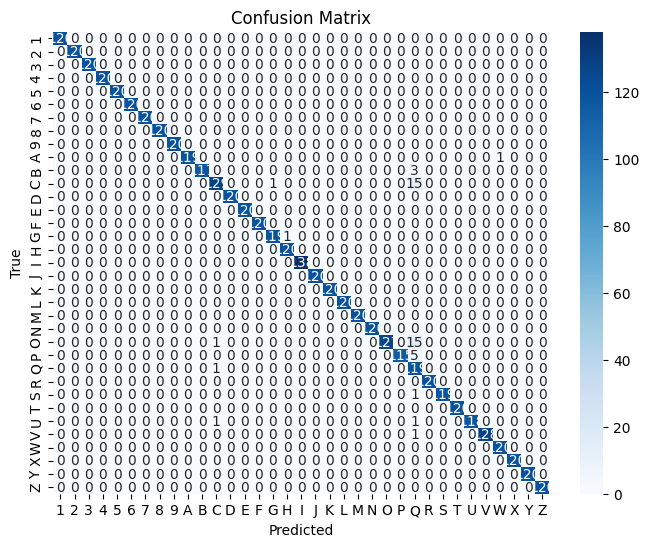

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# -------------------------------
# Step 1: Compute confusion matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred)

# Optional: get class names from label_map
class_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]

# -------------------------------
# Step 2: Plot confusion matrix
# -------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Real-time Inference
## Purpose

Demo the model live using webcam input.

Shows predictions in real-time for each hand sign
## Key Features

Uses MediaPipe Hands to extract landmarks on-the-fly.

Converts each frame to a 126-dim landmark vector.

Feeds the vector to the trained MLP model.

Uses a deque majority vote over last N frames to reduce flicker and false positives.

Displays predicted sign and confidence on the video

In [5]:
# realtime_landmark_demo.py
import cv2, numpy as np, collections, time
import mediapipe as mp
import tensorflow as tf
from collections import deque
import json

model = tf.keras.models.load_model("C:/Users/prati/OneDrive/Desktop/SignLanguage_Project/notebooks/landmark_model.h5")
with open("C:/Users/prati/OneDrive/Desktop/SignLanguage_Project/notebooks/ISL_dataset_split/label_map.json") as f:
    label_map = json.load(f)
inv_label_map = {v:k for k,v in label_map.items()}

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

cap = cv2.VideoCapture(0)
pred_q = deque(maxlen=7)  # temporal smoothing

def landmarks_to_vec(results):
    vec = np.zeros(21*3*2, dtype=np.float32)
    if results.multi_hand_landmarks and results.multi_handedness:
        hand_map = {}
        for idx, hland in enumerate(results.multi_hand_landmarks):
            label_h = results.multi_handedness[idx].classification[0].label
            coords = []
            for lm in hland.landmark:
                coords.extend([lm.x, lm.y, lm.z])
            hand_map[label_h] = coords
        left = hand_map.get("Left", [0]*(21*3))
        right = hand_map.get("Right", [0]*(21*3))
        vec = np.array(left + right, dtype=np.float32)
    return vec

while True:
    ret, frame = cap.read()
    if not ret: break
    img = cv2.flip(frame, 1)  # mirror for comfortable interaction
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    res = hands.process(rgb)
    if res.multi_hand_landmarks:
        for h in res.multi_hand_landmarks:
            mp_drawing.draw_landmarks(img, h, mp_hands.HAND_CONNECTIONS)
    vec = landmarks_to_vec(res)
    pred = model.predict(vec.reshape(1,-1))[0]
    idx = int(pred.argmax())
    conf = float(pred.max())
    pred_q.append((idx, conf))
    # majority vote
    votes = {}
    for p,c in pred_q:
        votes[p] = votes.get(p,0) + 1
    final_idx = max(votes, key=votes.get)
    final_conf = max(c for (i,c) in pred_q if i==final_idx)
    if final_conf > 0.6:
        text = f"{inv_label_map[final_idx]} ({final_conf:.2f})"
    else:
        text = "..."
    cv2.putText(img, text, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.imshow("Sign->Word Demo (Landmark)", img)
    if cv2.waitKey(1) & 0xFF == 27:
        break
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/